In [2]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from sklearn.naive_bayes import BernoulliNB

In [3]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [4]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [5]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [6]:
df.shape

(292, 15)

In [7]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [89]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [82]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [113]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [115]:
for col in X:
    X[col] = X[col].astype(int)

In [116]:
X['broken_link_score']

0      1
1      0
2      1
3      1
4      1
      ..
435    0
436    1
437    0
438    0
440    0
Name: broken_link_score, Length: 292, dtype: int64

In [117]:
X.shape

(292, 7)

In [118]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [122]:
model_choice = BernoulliNB()

In [123]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [124]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [125]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [126]:
y_pred_proba = clf.predict_proba(X_test)

In [127]:
np.round(accuracy_score(y_test, y_pred), 2)

0.85

In [128]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [129]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [130]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.87, 0.162)

In [131]:
tn, fp, fn, tp

(62, 12, 3, 20)

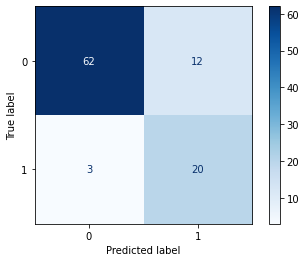

In [132]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [134]:
auc_score = auc(fpr, tpr)

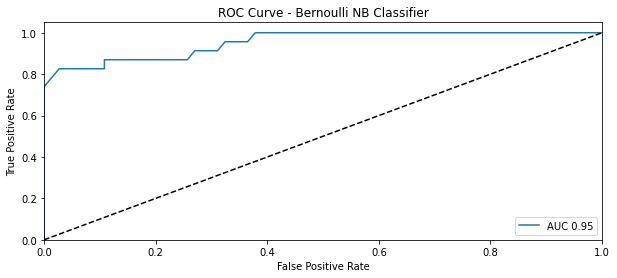

In [135]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli NB Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [136]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 1.9984643075547237
TPR 0.7391304347826086, FPR 0.0, Threshold 0.9984643075547237
TPR 0.8260869565217391, FPR 0.02702702702702703, Threshold 0.9843519641719499
TPR 0.8260869565217391, FPR 0.10810810810810811, Threshold 0.8010188502339551
TPR 0.8695652173913043, FPR 0.10810810810810811, Threshold 0.735690395396714
TPR 0.8695652173913043, FPR 0.13513513513513514, Threshold 0.7250578327124112
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.26954700633825296
TPR 0.8695652173913043, FPR 0.24324324324324326, Threshold 0.17632238375635578
TPR 0.8695652173913043, FPR 0.25675675675675674, Threshold 0.16838061489907666
TPR 0.9130434782608695, FPR 0.2702702702702703, Threshold 0.12117229687958225
TPR 0.9130434782608695, FPR 0.3108108108108108, Threshold 0.08774382214631858
TPR 0.9565217391304348, FPR 0.32432432432432434, Threshold 0.05842971268107445
TPR 0.9565217391304348, FPR 0.36486486486486486, Threshold 0.019245184234759505
TP

## Bootstrapped

In [137]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9477777777777778, Accuracy:0.8556701030927835
Iteration 1: AUC:0.9381338742393509, Accuracy:0.7938144329896907
Iteration 2: AUC:0.944770857814336, Accuracy:0.865979381443299
Iteration 3: AUC:0.9634703196347033, Accuracy:0.865979381443299
Iteration 4: AUC:0.9582881906825568, Accuracy:0.8969072164948454
Iteration 5: AUC:0.9222222222222222, Accuracy:0.7938144329896907
Iteration 6: AUC:0.9649038461538462, Accuracy:0.8969072164948454
Iteration 7: AUC:0.9161111111111112, Accuracy:0.7938144329896907
Iteration 8: AUC:0.9611872146118722, Accuracy:0.8762886597938144
Iteration 9: AUC:0.9165687426556992, Accuracy:0.8247422680412371
Iteration 10: AUC:0.9723084886128364, Accuracy:0.865979381443299
Iteration 11: AUC:0.9102434077079108, Accuracy:0.7835051546391752
Iteration 12: AUC:0.9365079365079365, Accuracy:0.8350515463917526
Iteration 13: AUC:0.9367724867724867, Accuracy:0.8247422680412371
Iteration 14: AUC:0.927796803652968, Accuracy:0.845360824742268
Iteration 15: AUC:0.945016

Iteration 137: AUC:0.9579905992949471, Accuracy:0.845360824742268
Iteration 138: AUC:0.9219444444444443, Accuracy:0.8041237113402062
Iteration 139: AUC:0.9407407407407408, Accuracy:0.845360824742268
Iteration 140: AUC:0.9324242424242425, Accuracy:0.8556701030927835
Iteration 141: AUC:0.924074074074074, Accuracy:0.8350515463917526
Iteration 142: AUC:0.96875, Accuracy:0.845360824742268
Iteration 143: AUC:0.8608333333333332, Accuracy:0.7731958762886598
Iteration 144: AUC:0.9412455934195064, Accuracy:0.8556701030927835
Iteration 145: AUC:0.8873144399460189, Accuracy:0.7525773195876289
Iteration 146: AUC:0.8922413793103449, Accuracy:0.8144329896907216
Iteration 147: AUC:0.90527950310559, Accuracy:0.7938144329896907
Iteration 148: AUC:0.9446022727272727, Accuracy:0.8556701030927835
Iteration 149: AUC:0.9110040567951317, Accuracy:0.845360824742268
Iteration 150: AUC:0.9271255060728746, Accuracy:0.865979381443299
Iteration 151: AUC:0.9252403846153846, Accuracy:0.8247422680412371
Iteration 152:

Iteration 272: AUC:0.9396825396825397, Accuracy:0.8350515463917526
Iteration 273: AUC:0.9145454545454546, Accuracy:0.8350515463917526
Iteration 274: AUC:0.9532258064516129, Accuracy:0.865979381443299
Iteration 275: AUC:0.9125939849624061, Accuracy:0.8350515463917526
Iteration 276: AUC:0.9236111111111112, Accuracy:0.8144329896907216
Iteration 277: AUC:0.9460996749729144, Accuracy:0.8556701030927835
Iteration 278: AUC:0.9233954451345755, Accuracy:0.8144329896907216
Iteration 279: AUC:0.9470551378446115, Accuracy:0.845360824742268
Iteration 280: AUC:0.8719574036511156, Accuracy:0.7938144329896907
Iteration 281: AUC:0.9471830985915493, Accuracy:0.8144329896907216
Iteration 282: AUC:0.9677248677248678, Accuracy:0.8762886597938144
Iteration 283: AUC:0.9276497695852534, Accuracy:0.8247422680412371
Iteration 284: AUC:0.9280555555555555, Accuracy:0.845360824742268
Iteration 285: AUC:0.9021164021164021, Accuracy:0.8247422680412371
Iteration 286: AUC:0.894973544973545, Accuracy:0.8144329896907216

Iteration 402: AUC:0.9727272727272728, Accuracy:0.9072164948453608
Iteration 403: AUC:0.9433333333333334, Accuracy:0.865979381443299
Iteration 404: AUC:0.9407894736842105, Accuracy:0.8865979381443299
Iteration 405: AUC:0.9213888888888889, Accuracy:0.8350515463917526
Iteration 406: AUC:0.8975124378109454, Accuracy:0.7938144329896907
Iteration 407: AUC:0.9469122426868906, Accuracy:0.8144329896907216
Iteration 408: AUC:0.9218036529680366, Accuracy:0.8350515463917526
Iteration 409: AUC:0.9661654135338346, Accuracy:0.9072164948453608
Iteration 410: AUC:0.8970747562296858, Accuracy:0.8144329896907216
Iteration 411: AUC:0.9333333333333332, Accuracy:0.845360824742268
Iteration 412: AUC:0.9134920634920635, Accuracy:0.8350515463917526
Iteration 413: AUC:0.9727777777777779, Accuracy:0.9072164948453608
Iteration 414: AUC:0.9230317273795534, Accuracy:0.8041237113402062
Iteration 415: AUC:0.9082089552238806, Accuracy:0.8144329896907216
Iteration 416: AUC:0.9726027397260275, Accuracy:0.87628865979381

Iteration 540: AUC:0.9355362946912243, Accuracy:0.8247422680412371
Iteration 541: AUC:0.8987012987012988, Accuracy:0.8144329896907216
Iteration 542: AUC:0.9184782608695652, Accuracy:0.845360824742268
Iteration 543: AUC:0.9266169154228856, Accuracy:0.865979381443299
Iteration 544: AUC:0.9500517598343685, Accuracy:0.8969072164948454
Iteration 545: AUC:0.9555555555555556, Accuracy:0.8762886597938144
Iteration 546: AUC:0.9197115384615384, Accuracy:0.8247422680412371
Iteration 547: AUC:0.8950501253132832, Accuracy:0.8041237113402062
Iteration 548: AUC:0.9597402597402598, Accuracy:0.845360824742268
Iteration 549: AUC:0.9311688311688312, Accuracy:0.8041237113402062
Iteration 550: AUC:0.9442424242424242, Accuracy:0.8350515463917526
Iteration 551: AUC:0.9433333333333334, Accuracy:0.845360824742268
Iteration 552: AUC:0.9375621890547263, Accuracy:0.8556701030927835
Iteration 553: AUC:0.9241718426501035, Accuracy:0.8350515463917526
Iteration 554: AUC:0.961388888888889, Accuracy:0.8865979381443299


Iteration 677: AUC:0.960618846694796, Accuracy:0.8556701030927835
Iteration 678: AUC:0.8709273182957393, Accuracy:0.8041237113402062
Iteration 679: AUC:0.9169312169312169, Accuracy:0.7938144329896907
Iteration 680: AUC:0.925189393939394, Accuracy:0.845360824742268
Iteration 681: AUC:0.9448757763975155, Accuracy:0.8762886597938144
Iteration 682: AUC:0.9091614906832297, Accuracy:0.8144329896907216
Iteration 683: AUC:0.9329573934837092, Accuracy:0.845360824742268
Iteration 684: AUC:0.9290382819794585, Accuracy:0.845360824742268
Iteration 685: AUC:0.9349945828819068, Accuracy:0.8350515463917526
Iteration 686: AUC:0.8946917808219178, Accuracy:0.8041237113402062
Iteration 687: AUC:0.933316430020284, Accuracy:0.865979381443299
Iteration 688: AUC:0.9325, Accuracy:0.8350515463917526
Iteration 689: AUC:0.8824485373781149, Accuracy:0.7835051546391752
Iteration 690: AUC:0.9384057971014493, Accuracy:0.8762886597938144
Iteration 691: AUC:0.9241363211951448, Accuracy:0.8247422680412371
Iteration 692:

Iteration 809: AUC:0.9243386243386243, Accuracy:0.8247422680412371
Iteration 810: AUC:0.9165763813651139, Accuracy:0.8247422680412371
Iteration 811: AUC:0.8993271221532091, Accuracy:0.8144329896907216
Iteration 812: AUC:0.9451923076923077, Accuracy:0.8556701030927835
Iteration 813: AUC:0.9379084967320261, Accuracy:0.8350515463917526
Iteration 814: AUC:0.9124338624338624, Accuracy:0.8144329896907216
Iteration 815: AUC:0.9322222222222222, Accuracy:0.8247422680412371
Iteration 816: AUC:0.9129566210045663, Accuracy:0.7835051546391752
Iteration 817: AUC:0.9386016451233843, Accuracy:0.865979381443299
Iteration 818: AUC:0.9079614604462475, Accuracy:0.8144329896907216
Iteration 819: AUC:0.9175228310502284, Accuracy:0.845360824742268
Iteration 820: AUC:0.9552238805970149, Accuracy:0.8762886597938144
Iteration 821: AUC:0.9447708578143361, Accuracy:0.8350515463917526
Iteration 822: AUC:0.9285714285714286, Accuracy:0.845360824742268
Iteration 823: AUC:0.9293650793650794, Accuracy:0.824742268041237

Iteration 945: AUC:0.9241293532338308, Accuracy:0.8247422680412371
Iteration 946: AUC:0.9386111111111111, Accuracy:0.865979381443299
Iteration 947: AUC:0.9039800995024876, Accuracy:0.8247422680412371
Iteration 948: AUC:0.9425, Accuracy:0.865979381443299
Iteration 949: AUC:0.941005291005291, Accuracy:0.8556701030927835
Iteration 950: AUC:0.9298654244306418, Accuracy:0.8144329896907216
Iteration 951: AUC:0.9227272727272727, Accuracy:0.845360824742268
Iteration 952: AUC:0.9354497354497354, Accuracy:0.8556701030927835
Iteration 953: AUC:0.9230158730158731, Accuracy:0.8247422680412371
Iteration 954: AUC:0.9023809523809524, Accuracy:0.8041237113402062
Iteration 955: AUC:0.9179606625258798, Accuracy:0.8041237113402062
Iteration 956: AUC:0.9348958333333334, Accuracy:0.8762886597938144
Iteration 957: AUC:0.9565217391304347, Accuracy:0.8969072164948454
Iteration 958: AUC:0.961388888888889, Accuracy:0.8762886597938144
Iteration 959: AUC:0.9058219178082192, Accuracy:0.7938144329896907
Iteration 96

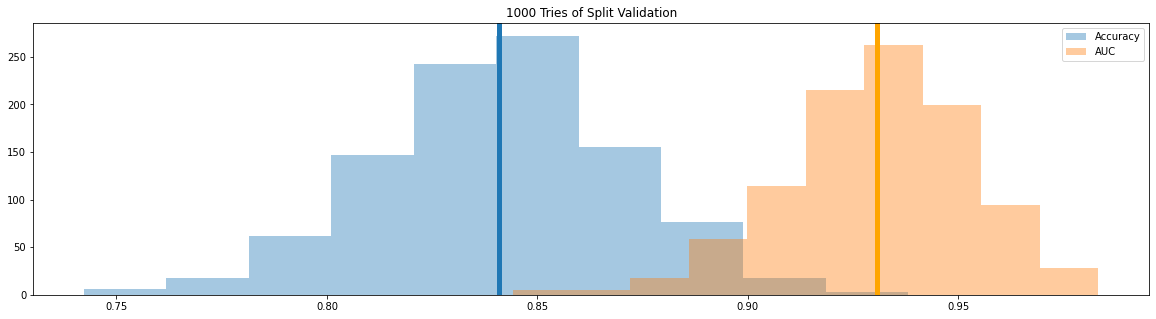

Accuracy mean: 0.84
AUC mean: 0.93


In [138]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [139]:
## Hyperparameters
{"alpha"    : [0, 1.0],
 "fit_prior" : [False, True]}

{'alpha': [0, 1.0], 'fit_prior': [False, True]}

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = BernoulliNB()

In [141]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [142]:
cv_results

array([0.98051948, 0.88798701, 0.93181818, 0.92857143, 0.94482759])

In [143]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [144]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [145]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [146]:
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9805194805194805

In [147]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best.values.ravel())
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.9527027027027026

#### Calculate Results

In [152]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
parameter_1 = []
parameter_2 = []
idx_train_data = []

## Hyperparameters
params = {"alpha": [0, 1],
          "fit_prior" : [False, True]}

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(params['alpha'])):
    for j in range(len(params['fit_prior'])):

        ## Fit the params
        model_choice = BernoulliNB\
        (alpha=params['alpha'][i],\
         fit_prior=params['fit_prior'][j])

        ## Do cross validation
        cv_results = cross_val_score(model_choice, X_train, y_train.values.ravel(), cv=kfold, scoring='roc_auc')

        ## Get the index best fold train data to be tested on dataset B
        idx = 0
        idx_train_best = []
        idx_test_best = []
        for train, test in kfold.split(X_train, y_train):
            if idx == np.argmax(cv_results):
                idx_train_best = train
                idx_test_best = test
            idx += 1

        ## Get the best fold train and test data
        X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
        y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

        X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
        y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

        ## Fit the model with the best fold data
        clf = model_choice.fit(X_train_best, y_train_best.values.ravel())

        ## Test the best fold to dataset B
        ## Check the AUC on dataset B
        y_test_proba = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
        auc_score = auc(fpr, tpr)

        best_fold.append(np.argmax(cv_results)+1)
        best_fold_auc.append(np.max(cv_results))
        dataset_b_auc.append(auc_score)
        parameter_1.append(params['alpha'][i])
        parameter_2.append(params['fit_prior'][j])
        idx_train_data.append(idx_train_best)

        print("Alpha: %s, Fit Prior: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
              % (params['alpha'][i], params['fit_prior'][j],\
                 np.max(cv_results), np.argmax(cv_results)+1, auc_score))

Alpha: 0, Fit Prior: False, Best Fold AUC: 0.9805194805194805 (Fold 1), Dataset B AUC: 0.9509400705052878
Alpha: 0, Fit Prior: True, Best Fold AUC: 0.9805194805194805 (Fold 1), Dataset B AUC: 0.9509400705052878
Alpha: 1, Fit Prior: False, Best Fold AUC: 0.9805194805194805 (Fold 1), Dataset B AUC: 0.9527027027027026
Alpha: 1, Fit Prior: True, Best Fold AUC: 0.9805194805194805 (Fold 1), Dataset B AUC: 0.9527027027027026


/Users/bahyhelmihp/Library/Python/3.7/lib/python/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/bahyhelmihp/Library/Python/3.7/lib/python/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/bahyhelmihp/Library/Python/3.7/lib/python/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/bahyhelmihp/Library/Python/3.7/lib/python/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/bahyhelmihp/Library/Python/3.7/lib/python/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric e

In [153]:
df_result = pd.DataFrame({"alpha": parameter_1, "fit_prior": parameter_2,\
                          "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,alpha,fit_prior,fold_index,best_fold_auc,test_auc,train_idx
0,0,False,1,0.980519,0.950940,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
1,0,True,1,0.980519,0.950940,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
2,1,False,1,0.980519,0.952703,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."
3,1,True,1,0.980519,0.952703,"[35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48, 4..."


In [154]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,alpha,fit_prior,fold_index,best_fold_auc,test_auc
0,0,False,1,0.980519,0.95094
1,0,True,1,0.980519,0.95094


In [155]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,alpha,fit_prior,fold_index,best_fold_auc,test_auc
2,1,False,1,0.980519,0.952703
3,1,True,1,0.980519,0.952703


In [157]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_alpha = df_result[df_result.test_auc == df_result.test_auc.max()]['alpha'].iloc[0]
best_fit_prior = df_result[df_result.test_auc == df_result.test_auc.max()]['fit_prior'].iloc[0]

In [158]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [159]:
clf = BernoulliNB\
        (alpha=best_alpha,\
         fit_prior=best_fit_prior)

In [160]:
clf.fit(X_train_chosen, y_train_chosen.values.ravel())
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [161]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.953
Accuracy: 0.804 
Precision: 0.556 
Recall: 0.870 
F1 Score: 0.678 


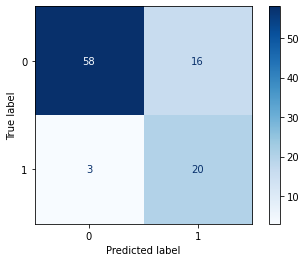

In [162]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [163]:
print("True Positive: %s" % tp)
print("False Pasitive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 20
False Pasitive: 16
True Negative: 58
False Negative: 3


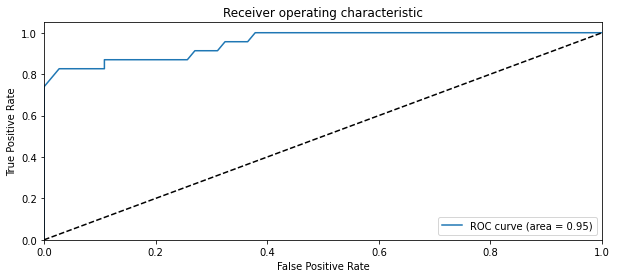

In [164]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Dump To Pickle

In [42]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [43]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()